# Non-Federated EMNIST Baseline Training

This colab has three main parts:

*   It trains a non-federated model on a flattened and shuffled (that is,
    non-federated) view of the the
    [Federated EMNIST](https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/emnist/load_data)
    dataset. The model architecture matches the simple CNN from the paper
    [Communication-Efficient Learning of Deep Networks from Decentralized Data](https://arxiv.org/abs/1602.05629).
    This (currently untuned) training reaches an accuracy of about 98% with
    vanilla SGD. This is intended to serve as a baseline for simulated federated
    training on the Fed EMNIST dataset.

*   It uses this model to examine the Fed EMNIST dataset, showing it has
    interesting variation across users.

*   As a sanity check, it shows an equivalent model can be trained using the
    `Federated Averaging` implementation from `tff.learning` applied to a
    non-federated (that is, flattened and shuffled) view of the data.

In [0]:
# DO NOT SUBMIT - re-enable these
#!pip install tensorflow_federated
#!pip install tensorflow_gan

In [0]:
from __future__ import absolute_import, division, print_function

import collections
import functools
import numpy as np
import time

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_gan as tfgan

tf.compat.v1.enable_v2_behavior()

# Training a baseline model with Keras

## Data

Download the data, and lightly reformat for use in Keras.

In [0]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [0]:
Example = collections.namedtuple('Example', ['x', 'y'])

BATCH_SIZE = 10
SHUFFLE_BUFFER = 10000


def element_fn(element):
  return Example(
      x=tf.reshape(element['pixels'], [-1]),
      y=tf.reshape(element['label'], [1]))


def preprocess_train(dataset, batch_size=BATCH_SIZE):
  return dataset.map(element_fn).apply(
      tf.data.experimental.shuffle_and_repeat(
          buffer_size=SHUFFLE_BUFFER, count=-1)).batch(batch_size)


def preprocess_test(dataset):
  return dataset.map(element_fn).batch(100, drop_remainder=False)


flat_train_data = preprocess_train(
    emnist_train.create_tf_dataset_from_all_clients())
flat_test_data = preprocess_test(
    emnist_test.create_tf_dataset_from_all_clients())

## Model

In [5]:
def build_cnn():
  """The CNN model used in https://arxiv.org/abs/1602.05629.

  The number of parameters (1,663,370) matches what is reported in the paper.
  """
  data_format = 'channels_last'
  input_shape = [28, 28, 1]

  # Alternatively:
  # data_format = 'channels_first'
  # input_shape = [1, 28, 28]

  max_pool = lambda: tf.keras.layers.MaxPooling2D(
      pool_size=(2, 2), padding='same', data_format=data_format)
  conv2d = functools.partial(
      tf.keras.layers.Conv2D,
      kernel_size=5,
      padding='same',
      data_format=data_format,
      activation=tf.nn.relu)

  model = tf.keras.models.Sequential([
      tf.keras.layers.Reshape(target_shape=input_shape, input_shape=(28 * 28,)),
      conv2d(filters=32),
      max_pool(),
      conv2d(filters=64),
      max_pool(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation=tf.nn.relu),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax),
  ])

  model.compile(
      loss=tf.keras.losses.sparse_categorical_crossentropy,
      # This learning rate has not been tuned.
      optimizer=tf.keras.optimizers.SGD(learning_rate=0.02),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

  return model


build_cnn().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

## Training and Evaluation

In [0]:
# Hyperparameters
NUM_ROUNDS = 10
BATCHES_PER_ROUND = 1000

In [0]:
model = build_cnn()
# We set steps_per_epoch and epochs just to break training up in reasonable "chunks".
# These aren't really epochs over the full dataset.
# Training could take about 8 minutes.
model.fit(flat_train_data, steps_per_epoch=BATCHES_PER_ROUND, epochs=NUM_ROUNDS)

Epoch 1/10
1000/1000 [==============================] - 41s 41ms/step - loss: 1.2906 - sparse_categorical_accuracy: 0.5727
Epoch 2/10
1000/1000 [==============================] - 24s 24ms/step - loss: 0.2211 - sparse_categorical_accuracy: 0.9354
Epoch 3/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.1412 - sparse_categorical_accuracy: 0.9572
Epoch 4/10
1000/1000 [==============================] - 24s 24ms/step - loss: 0.1074 - sparse_categorical_accuracy: 0.9653
Epoch 5/10
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0795 - sparse_categorical_accuracy: 0.9754
Epoch 6/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0598 - sparse_categorical_accuracy: 0.9808
Epoch 7/10
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0645 - sparse_categorical_accuracy: 0.9804
Epoch 8/10
 632/1000 [=================>............] - ETA: 9s - loss: 0.0619 - sparse_categorical_accuracy: 0.9829

There are 40,832 test examples, so we take 409 eval steps with a test batch size
of 100:

In [0]:
_ = model.evaluate(flat_test_data)

    409/Unknown - 51s 125ms/step - loss: 0.1082 - sparse_categorical_accuracy: 0.9671

# Aside: Do some users have hard-to-classify data?

Since this is a public dataset intended for research, one interesting thing we
can do with the model is to use the above baseline model to see if some users
have hard-to-classify data. This is way of verifying that the Federated EMNIST
dataset has interesting variation across users.

In [0]:
def display_raw_emnist(data, grid_width=25):
  """A helper function to display images from Fed EMNIST datasets."""
  # List of numpy images
  img_data = np.array([x['pixels'].numpy() for x in data])
  img_data = np.reshape(img_data, (-1, 28, 28, 1))
  num_rows = int(np.ceil(len(img_data) / grid_width))
  needed_images = num_rows * grid_width
  tmp = np.zeros((needed_images, 28, 28, 1))
  s = img_data.shape
  tmp[:s[0], :s[1], :s[2]] = img_data
  img_data = tmp
  img_grid = tfgan.eval.python_image_grid(
      img_data, grid_shape=(num_rows, grid_width))

  h = 20
  w = h * (grid_width / num_rows)
  plt.figure(figsize=(h, w))
  plt.axis('off')
  plt.imshow(np.squeeze(img_grid), cmap='binary')
  plt.show()

Display the data from clients with accuracy below a threshold.

client 25 (f0048_00) with  54 examples has accuracy  77.78%


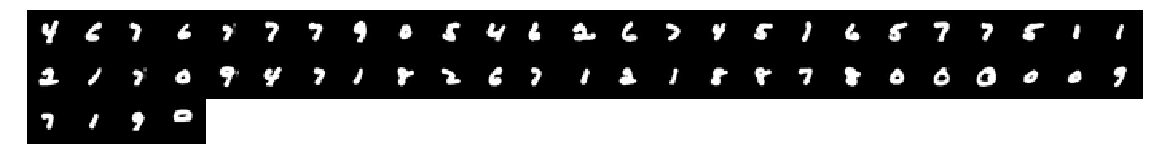

client 137 (f0232_28) with  58 examples has accuracy  84.48%


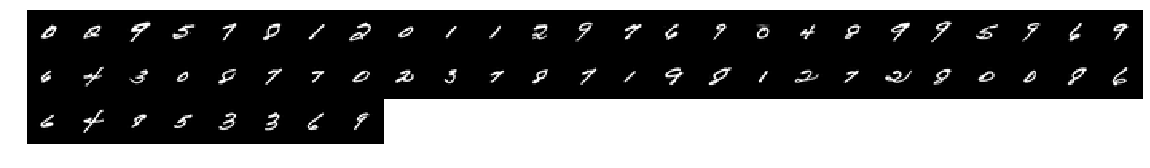

client 268 (f0447_21) with  60 examples has accuracy  81.67%


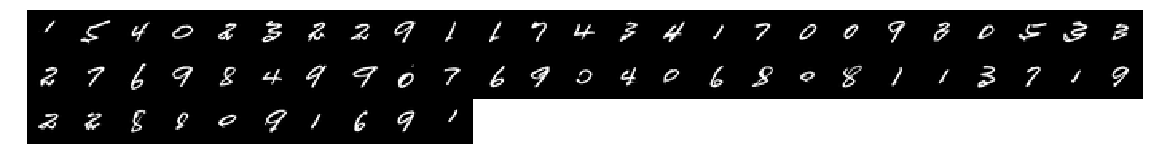

client 522 (f0719_05) with  56 examples has accuracy  83.93%


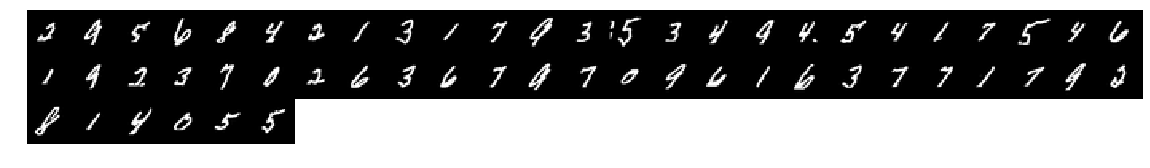

client 817 (f1016_36) with  62 examples has accuracy  83.87%


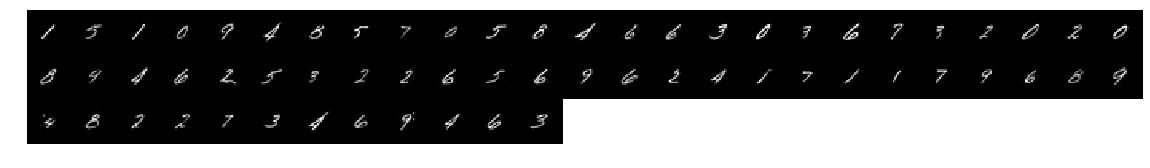

client 1007 (f1209_31) with  22 examples has accuracy  81.82%


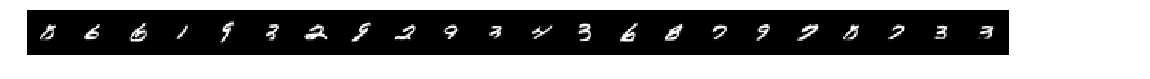

client 1129 (f1331_49) with  89 examples has accuracy  84.27%


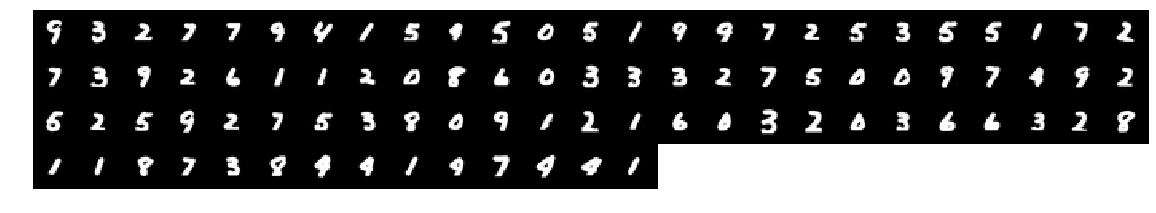

client 1809 (f2023_12) with  87 examples has accuracy  81.61%


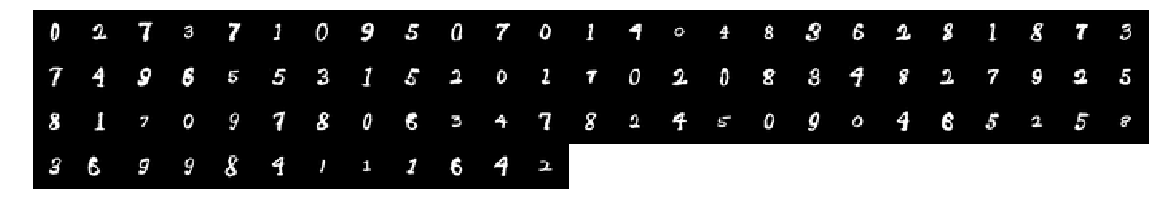

client 1810 (f2024_20) with 110 examples has accuracy  70.00%


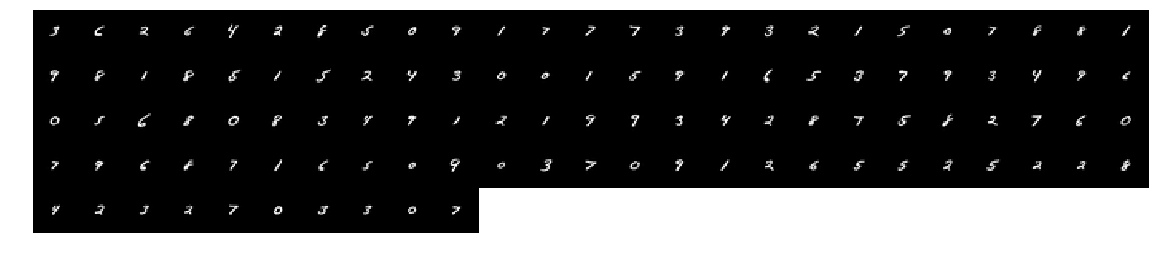

client 1929 (f2145_89) with  87 examples has accuracy  80.46%


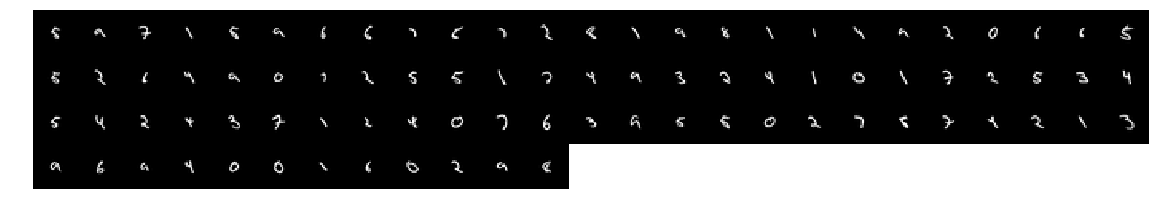

client 1930 (f2146_84) with 105 examples has accuracy  82.86%


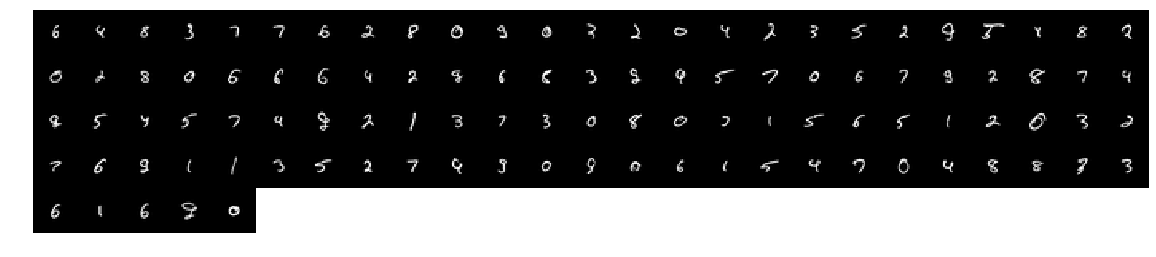

client 1992 (f2208_81) with 102 examples has accuracy  83.33%


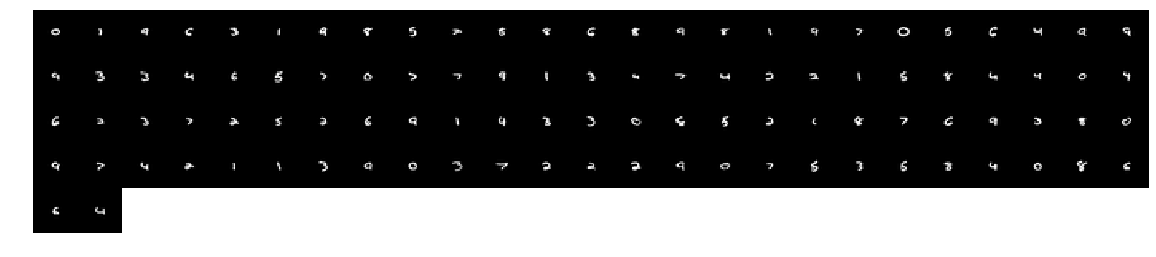

client 2022 (f2238_86) with 105 examples has accuracy  80.95%


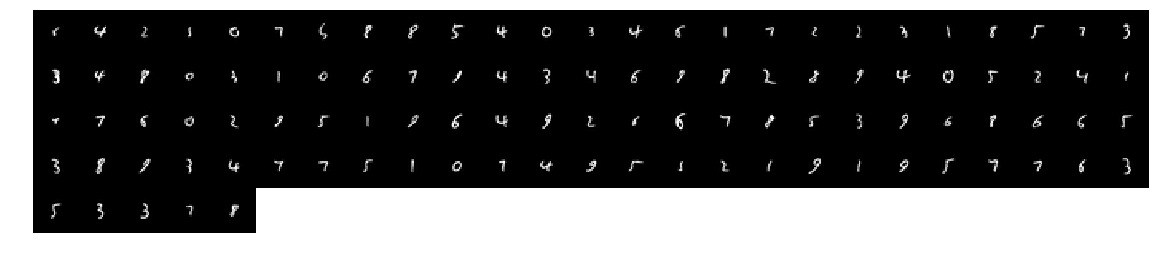

client 2028 (f2244_94) with 106 examples has accuracy  75.47%


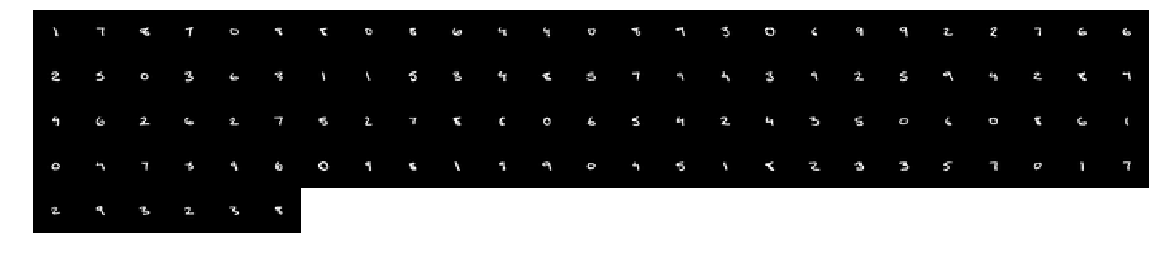

client 2032 (f2248_68) with  87 examples has accuracy  66.67%


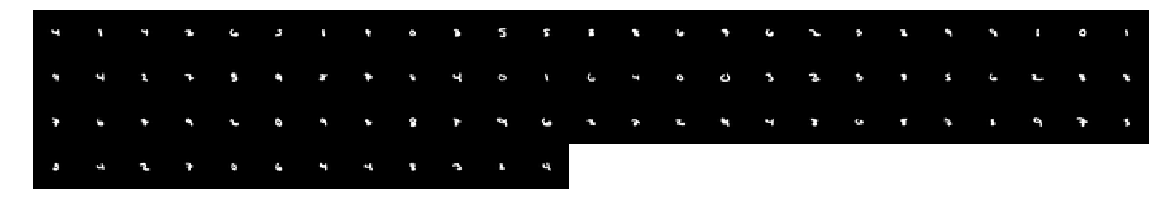

client 2256 (f2472_83) with  92 examples has accuracy  82.61%


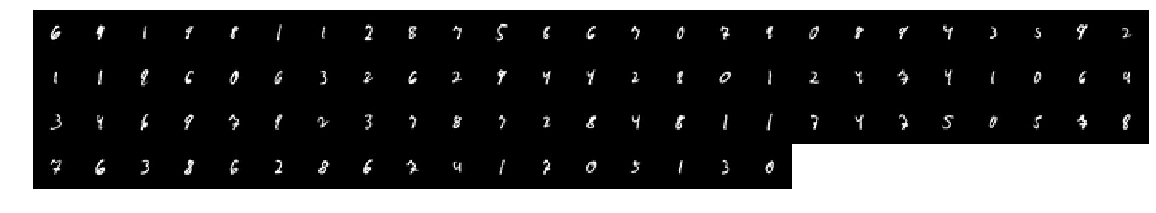

client 2308 (f2524_58) with  82 examples has accuracy  80.49%


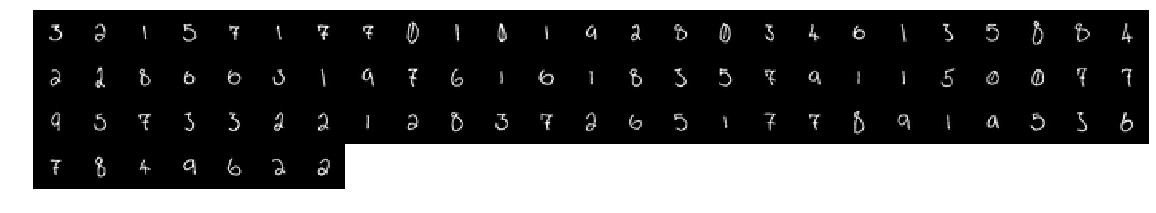

client 2380 (f2596_86) with 114 examples has accuracy  81.58%


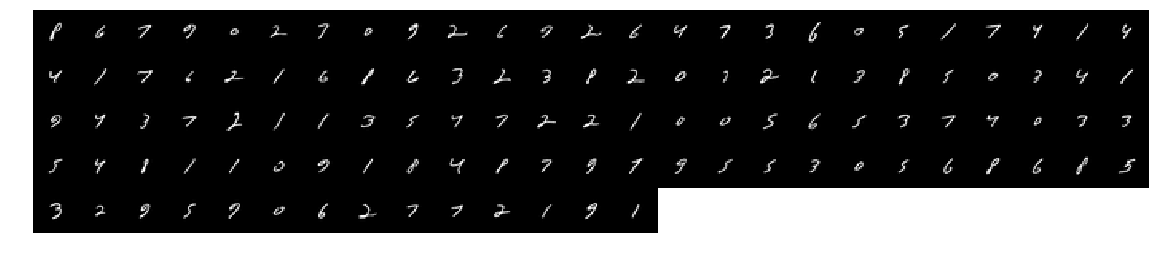

client 2435 (f3151_13) with 106 examples has accuracy  69.81%


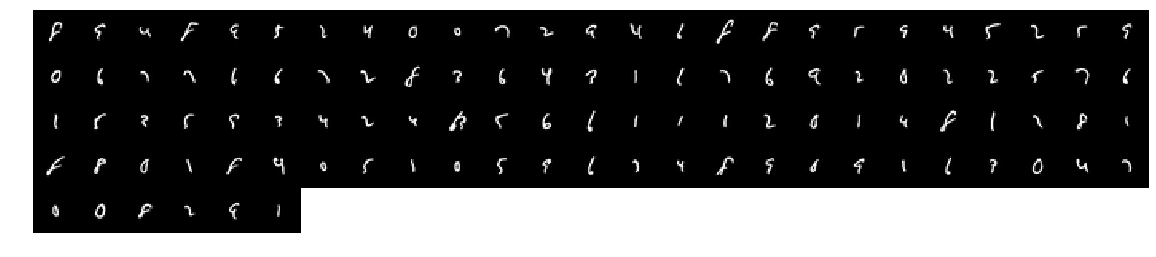

client 2483 (f3200_41) with 112 examples has accuracy  83.04%


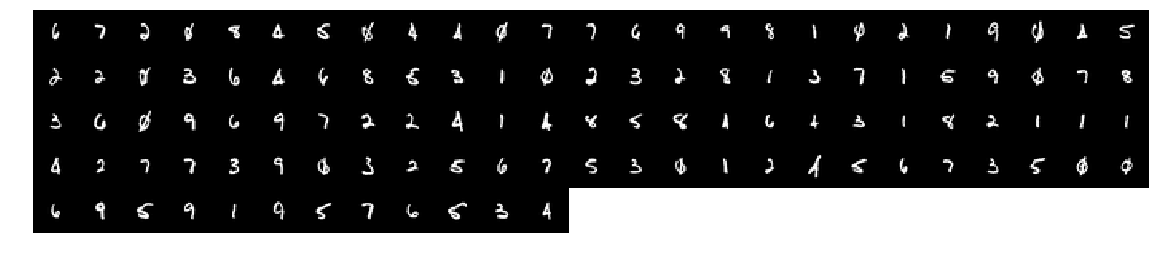

client 2494 (f3211_20) with 109 examples has accuracy  80.73%


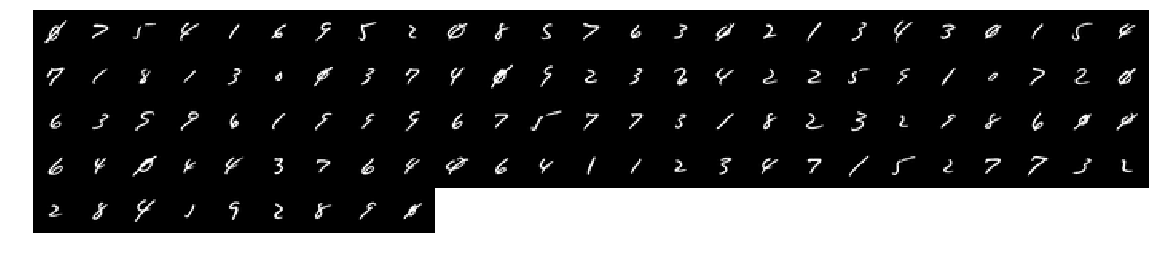

client 2786 (f3503_07) with 116 examples has accuracy  80.17%


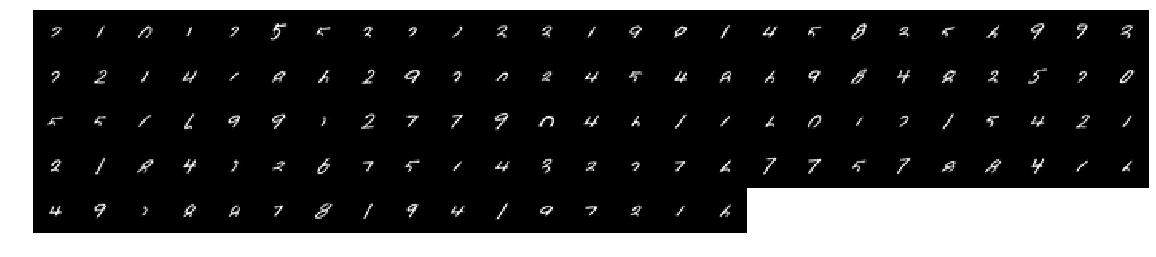

client 2925 (f3642_03) with  64 examples has accuracy  76.56%


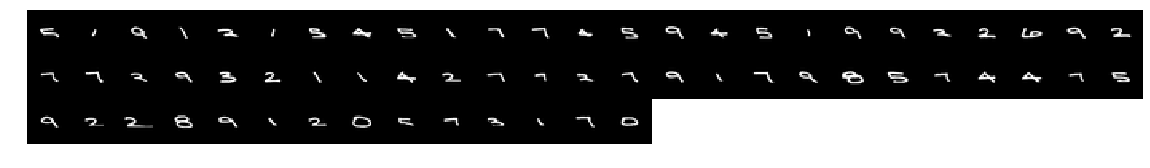

client 2948 (f3665_22) with 110 examples has accuracy  82.73%


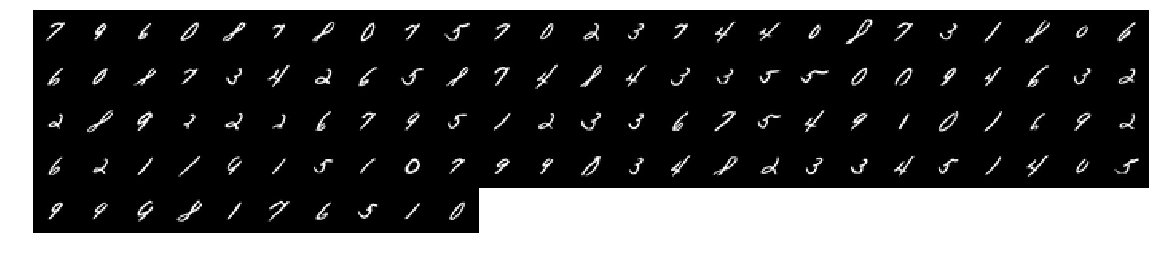

client 3235 (f3951_47) with  81 examples has accuracy  83.95%


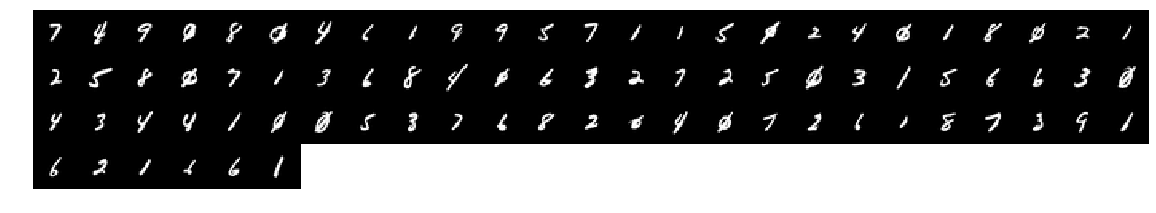

client 3293 (f4010_12) with 106 examples has accuracy  77.36%


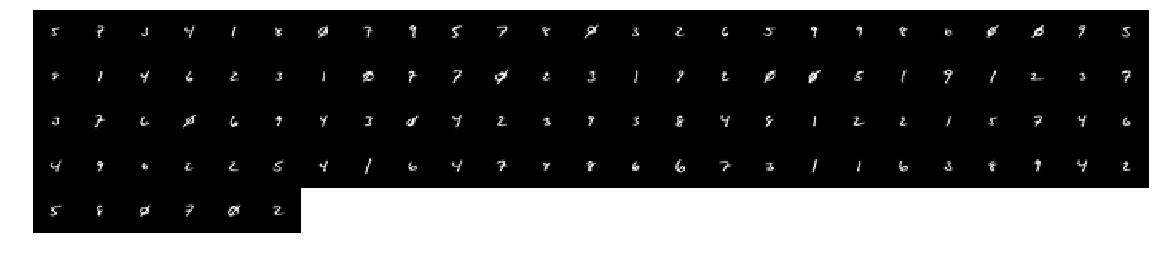

In [0]:
accuracy_by_client_id = {}
THRESHOLD = 0.85

for i, client_id in enumerate(emnist_train.client_ids):
  raw_data = emnist_train.create_tf_dataset_for_client(client_id)
  num_examples = sum([1 for _ in raw_data])
  loss, accuracy = model.evaluate(preprocess_test(raw_data), verbose=0)
  accuracy_by_client_id[client_id] = accuracy
  if accuracy < THRESHOLD:
    print('client {} ({}) with {:3d} examples has accuracy {:6.2f}%'.format(
        i, client_id, num_examples, 100 * accuracy))
    display_raw_emnist(raw_data)

# Replicating the baseline with `tff.learning`

Here we show how to use the `tff.learning` code to replicate the non-federated
baseline. However, critically the training is still essentially
non-federated --- that is, this is a santiy check, not a proper simulation of
federated learning.

The approach is based on the fact that if each "client" has IID shuffled data
from a centralized training set, and we use the `FederatedAveraging` algorithm
with one client per round (so there is no actual averaging), then this is
algorithmically equivalent to running SGD centrally.

In [0]:
dummy_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                    next(iter(flat_train_data.take(1))))


def create_tff_model():
  keras_model = build_cnn()
  return tff.learning.from_compiled_keras_model(
      build_cnn(), dummy_batch=dummy_batch)


fed_avg_process = tff.learning.build_federated_averaging_process(
    model_fn=create_tff_model)

Work around a dataset issue to construct a sequence of Datasets each containing
`BATCHES_PER_ROUND` batches of size `BATCH_SIZE` from the regular shuffled
training data.

In [0]:
# Dataset of "big" batches to work around window issue (b/134945216)
tff_train_data = preprocess_train(
    emnist_train.create_tf_dataset_from_all_clients(),
    batch_size=BATCH_SIZE * BATCHES_PER_ROUND)

tff_train_data_iter = iter(tff_train_data)


def next_client_dataset():
  # Grab the next "big" batch, create a dataset, and split into regular batches.
  client_data = tf.data.Dataset.from_tensor_slices(next(tff_train_data_iter))
  return client_data.batch(BATCH_SIZE)

Now we are ready to do some training. We do 10 rounds of 1000 batches per round,
but the split between rounds doesn't really matter.

In [11]:
state = fed_avg_process.initialize()

print('Running Federated Averaging')
start_time = time.time()
for i in range(NUM_ROUNDS):
  # Run one round of FederatedAveraging, on a single client.
  round_start_time = time.time()
  state, metrics = fed_avg_process.next(state, [next_client_dataset()])
  finish_time = time.time()
  print('Round {:3d} took {:5.2f} seconds (total {:4.0f} seconds). '
        'Training metrics: {}'.format(i, finish_time - round_start_time,
                                      finish_time - start_time, metrics))

Running Federated Averaging
Round   0 took   10.22 seconds (total       10 seconds). Training metrics: <sparse_categorical_accuracy=0.126,loss=2.29615>
Round   1 took   12.32 seconds (total       23 seconds). Training metrics: <sparse_categorical_accuracy=0.199,loss=2.26583>
Round   2 took   11.87 seconds (total       34 seconds). Training metrics: <sparse_categorical_accuracy=0.25,loss=2.20102>
Round   3 took   11.74 seconds (total       46 seconds). Training metrics: <sparse_categorical_accuracy=0.413,loss=1.9517>
Round   4 took   13.51 seconds (total       60 seconds). Training metrics: <sparse_categorical_accuracy=0.626,loss=1.2656>
Round   5 took   11.64 seconds (total       71 seconds). Training metrics: <sparse_categorical_accuracy=0.791,loss=0.712945>
Round   6 took   10.45 seconds (total       82 seconds). Training metrics: <sparse_categorical_accuracy=0.849,loss=0.529598>
Round   7 took   11.95 seconds (total       94 seconds). Training metrics: <sparse_categorical_accuracy=0

In [0]:
print('Final model evaluation on test data')
# Create a regular Keras model to use for eval.
keras_model = build_cnn()
tff.learning.assign_weights_to_keras_model(keras_model, state.model)
_ = keras_model.evaluate(flat_test_data)

Final model evaluation on test data
     41/Unknown - 58s 1s/step - loss: 0.0618 - sparse_categorical_accuracy: 0.9816